<h1>Estimation de la covariance intégrée<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulations-des-données-:-Mouvement-Brownien-Géométrique" data-toc-modified-id="Simulations-des-données-:-Mouvement-Brownien-Géométrique-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulations des données : Mouvement Brownien Géométrique</a></span></li><li><span><a href="#Implémentation-de-l'estimateur-de-Malliavin-Mancino" data-toc-modified-id="Implémentation-de-l'estimateur-de-Malliavin-Mancino-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implémentation de l'estimateur de Malliavin Mancino</a></span></li><li><span><a href="#Reconstruction-de-la-covolatilité-par-inversion-de-Fejér-et-de-Dirichlet" data-toc-modified-id="Reconstruction-de-la-covolatilité-par-inversion-de-Fejér-et-de-Dirichlet-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reconstruction de la covolatilité par inversion de Fejér et de Dirichlet</a></span></li><li><span><a href="#Implémentation-de-l'estimateur-de-Hayashi-Yoshida"" data-toc-modified-id="Implémentation-de-l'estimateur-de-Hayashi-Yoshida-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Implémentation de l'estimateur de Hayashi Yoshida</a></span></li><li><span><a  href="#Test-des-implémentations" data-toc-modified-id="Test-des-implémentations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test des implémentations</a></span></li><li><span><a href="#Etude-de-l'estimateur-de-Malliavin-Mancino" data-toc-modified-id="Etude-de-l'estimateur-de-Malliavin-Mancino-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Etude de l'estimateur de Malliavin Mancino</a></span><ul class="toc-item">

In [1]:
import math
import time
import numpy as np
from cmath import exp
from numpy.fft import fft
from numpy.fft import fftfreq
from scipy.integrate import quad
from scipy.stats import random_correlation
from scipy.stats import linregress
from progressbar import ProgressBar
import random
import finufft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
#from matplotlib import rc
#rc('text', usetex=True) # *
# * Permet de faire des graphes avec matplotlib dans le même style que latex
# * nécessite que latex soit installé sur l'ordinateur et ajouté aux variables d'environnement, supprimer si erreur

# Simulations des données : Mouvement Brownien Géométrique

In [66]:
def cov_matrix(sigmas, corrs) :
    """ Builds the covariance matrix
      sigmas : (sigma1, sigma2,...,sigmad) the volatilities
      corrs : matrix dxd containing the correlations corrs[i][j] = corr(dWi, dWj)
    """
    sigma = []
    d = len(sigmas)
    for i in range(d) :
        l = []
        for j in range(d) :
            l.append(sigmas[i]*sigmas[j]*corrs[i][j])
        sigma.append(l)
    return sigma
    
def GBM(mu, Cov, start_price, time_vect) :
    """ Generates a multivariate Geometric Brownian Motion
       mu : array dx1 containing the drifts
       sigma : covariance matrix dxd
       start_price : array dx1 containing the prices at t=0
       time_vect : array dx1 time ticks vector
    """
    
    dim = np.size(start_price)
    n = len(time_vect)
    
    if not isPD(Cov) :
        Cov = nearestPD(Cov)

    A = np.linalg.cholesky(Cov) #Cov HAS to be symetric definite positive
    S = np.zeros([dim, n])
    S[:, 0] = start_price
    for i in range(1, n):    
        drift = (mu- 0.5 * np.diag(Cov)) * (time_vect[i] - time_vect[i-1])
        Z = np.random.normal(0, 1, dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(time_vect[i] - time_vect[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S

def time_rescale(time_vect, p=2*np.pi) :
    """Rescales a time vector from [0 T] to [0 p]
       time_vect : time vector to rescale, sorted in ascending order
       p : period
    """
    return [p*(time_vect[i]-time_vect[0])/(time_vect[-1]-time_vect[0]) for i in range(len(time_vect))]

def Nyquist_freq(time_vect_res, p=2*np.pi) :
    """Computes the Nyquist frequency for a rescaled time vector
       time_vect_res : rescaled time vector, sorted in ascending order
    """
    dt = math.inf
    for i in range(len(time_vect_res)-1) :
        res = time_vect_res[i+1] - time_vect_res[i]
        if res < dt :
            dt = res
    return math.floor(p/(2*dt))

# /!\ GBM retourne des listes de prix pas des log-prix

In [3]:
def nearestPD(A):
    """Find the nearest (for the Frobenius norm) positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2] 
    
    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6

    A : list or np.array, symmetric
    
    taken from https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194
    with some modifications
    """
    
    A = np.asarray(A)
    _, s, V = np.linalg.svd(A)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (A + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

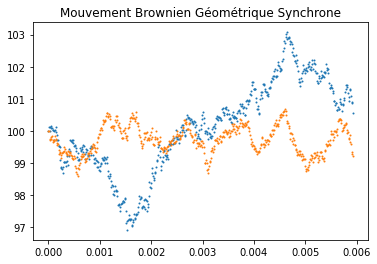

Corrélation des dérivées des log-prix : [[1.         0.27248401]
 [0.27248401 1.        ]]
Corrélation en paramètre : [[1, 0.3], [0.3, 1]]


In [4]:
#Exemple de simulation pour des données synchrones
#Pour visualiser les courbes du mouvement brownien géométrique
n = 2**9+1
mu = [0.01, 0.01]
sigmas = [np.sqrt(0.2), np.sqrt(0.1)]
corrs = [[1, 0.3], [0.3, 1]]
Cov = cov_matrix(sigmas, corrs)
start_price = [100, 100]
dt = 1/86400

d = len(mu)

time_vect = [i*dt for i in range(n)]
tmax = time_vect[-1]
tmin = time_vect[0]
time_vect_res = time_rescale(time_vect, 2*np.pi)

S = GBM(mu, Cov, start_price, time_vect)

for i in range(d) :
    plt.scatter(time_vect, S[i], s=1)
plt.title("Mouvement Brownien Géométrique Synchrone")
plt.show()
print("Corrélation des dérivées des log-prix :", np.corrcoef(np.diff(np.log(S))))
print("Corrélation en paramètre :", corrs)

In [5]:
def downsample(time_vect, S, percent) :
    """
    Uniform downsample of price vectors
    time_vect : 1D vector of synchronous times
    S : synchronous GBM matrix
    percent : percentage of downsample
    """
    
    new_len = len(time_vect) - math.floor(percent*len(time_vect))
    new_times = []
    new_prices = []
    
    for asset in S : 
        indices = [0] + random.sample(range(1, len(time_vect)-1), new_len-2) + [len(time_vect)-1]
        new_prices.append([asset[i] for i in sorted(indices)])
        new_times.append([time_vect[i] for i in sorted(indices)])
    
    return new_times, new_prices

def exponential_arrival(la, time_vect, S) :
    """
    Exponential downsample of price vectors
    la : parameters of the Poisson distribution
    time_vect : 1D vector of synchronous times
    S : synchronous GBM matrix
    """
    n = len(time_vect)
    time_vect = np.array(time_vect)
    new_prices = []
    new_times = []
    for i in range(len(S)) :
        v = -la[i]*np.log(np.random.rand(n))
        t = v.cumsum()
        events = np.where(t < n, t, -1)
        events = list(map(int, events))
        events_set = set(events)
        events_set.discard(-1)
        events = sorted(list(events_set))
        new_times.append(time_vect[events])
        new_prices.append(S[i][events])
    return new_times, new_prices

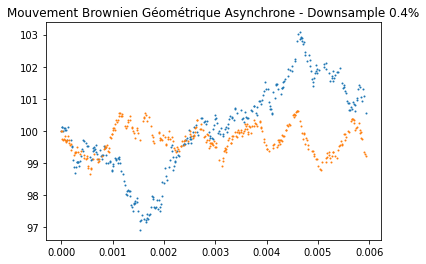

Corrélation des dérivées des log-prix : [[1.         0.27248401]
 [0.27248401 1.        ]]
Corrélation en paramètre : [[1, 0.3], [0.3, 1]]


In [6]:
#Exemple de downsample uniforme
ds = 0.4
new_times, new_prices = downsample(time_vect, S, ds)

for i in range(len(new_times)) :
    plt.scatter(new_times[i], new_prices[i], s=1)

plt.title("Mouvement Brownien Géométrique Asynchrone - Downsample {}%".format(ds))
plt.show()
print("Corrélation des dérivées des log-prix :", np.corrcoef(np.diff(np.log(S))))
print("Corrélation en paramètre :", corrs)

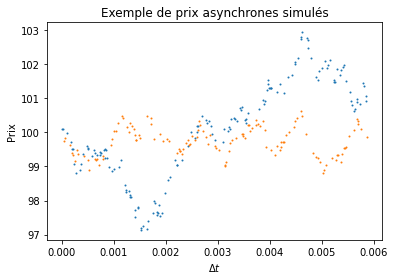

Corrélation des dérivées des log-prix : [[1.         0.27248401]
 [0.27248401 1.        ]]
Corrélation en paramètre : [[1, 0.3], [0.3, 1]]


In [7]:
#Exemple de downsample exponentiel
new_times, new_prices = exponential_arrival([3,4], time_vect, S)

for i in range(len(new_times)) :
    plt.scatter(new_times[i], new_prices[i], s=1)

plt.title("Exemple de prix asynchrones simulés")
plt.xlabel(r"$\Delta t$")
plt.ylabel("Prix")
plt.show()
print("Corrélation des dérivées des log-prix :", np.corrcoef(np.diff(np.log(S))))
print("Corrélation en paramètre :", corrs)

# Implémentation de l'estimateur de Malliavin Mancino

## Calcul classique des coefficients de Fourier

### For loop

In [8]:
def loop(time_vect_res, price_vect, cutoff_freq = math.inf) :
    """Compute the Fourier coefficients a given price vector for a rescaled time vector
       Returns the results as a dictionnary
       time_vect_res : rescaled time vector, sorted in ascending order
       price_vect : price vector of a product with respect to the time vector not log(price)
       cutoff_freq : determines the number of Fourier coefficients computed (2N+1). By default, set to Nyquist frequency
    """
    cutoff_freq = min(cutoff_freq, Nyquist_freq(time_vect_res))
    n = len(time_vect_res)
    dico_coeffs = {}
    dico_delta = {l : np.log(price_vect[l+1]) - np.log(price_vect[l]) for l in range(n-1)}
    start_time = time.time()
    
    for k in range(-cutoff_freq, cutoff_freq + 1) :
        c = 0
        for l in range(n-1) :
            res = complex(0, - k*time_vect_res[l])
            c += (math.e ** res) * dico_delta[l]
        dico_coeffs[k] = c 
    end_time = time.time()
    return dico_coeffs, end_time - start_time

### Vectorised

In [9]:
def vectorised(time_vect_res, price_vect, cutoff_freq = math.inf):
    N = min(cutoff_freq, Nyquist_freq(time_vect_res))

    n = len(time_vect_res)
    delta = [np.log(price_vect[k+1]) - np.log(price_vect[k]) for k in range(0, n-1)]
    delta = np.transpose([delta])
    start_time = time.time()

    lis = np.asarray([list(range(1,N+1))])
    c_n = np.exp(-1j*np.transpose(lis).dot(np.asarray([time_vect_res[:-1]]))).dot(delta)
    
    dico_coeffs = {}
    
    for k in range(0, N+1) :
        if k == 0 : 
            dico_coeffs[k] = np.sum(delta)
        else : 
            dico_coeffs[k] = c_n[k-1][0]
            dico_coeffs[-k] = np.conj(c_n[k-1][0])

    end_time = time.time()

    return (dico_coeffs, end_time-start_time)

### Fast Fourier Transform

In [10]:
def fast_fourier_transform(time_vect_res, price_vect, cutoff_freq = math.inf) :
    N = min(cutoff_freq, Nyquist_freq(time_vect_res))
    
    n = len(time_vect_res)
    delta = [np.log(price_vect[k+1]) - np.log(price_vect[k]) for k in range(0, n-1)]
    
    start_time = time.time()
    res = fft(delta, min(2*N, n)) #pour avoir -N, N coefficients
    end_time = time.time()
    dic = {}
    frequencies = fftfreq(len(res), 1/len(res))
    for i in range(len(res)) : 
        dic[int(frequencies[i])] = res[i]
    return dic, end_time - start_time

### Zero Padded Fast Fourier Transform

In [11]:
def zero_padded_fft(time_vect_res, price_vect) :
    n = len(time_vect_res)
    
    step = time_vect_res[1] - time_vect_res[0]
    for i in range(n-1) :
        if time_vect_res[i+1] - time_vect_res[i] < step :
            step = time_vect_res[i+1] - time_vect_res[i]
    
    delta = [np.log(price_vect[k+1]) - np.log(price_vect[k]) for k in range(0, n-1)]
    expected_length = math.floor(2*np.pi/step) + 1
    start_time = time.time()
    new_delta = [0 for i in range(expected_length)]
    for j in range(n-1) :
        l = math.floor(expected_length*time_vect_res[j]/(2*np.pi))
        new_delta[l] = delta[j]
    
    result = fft(new_delta)
    end_time = time.time()
    
    dic = {}
    frequencies = fftfreq(len(result), 1/len(result))
    for i in range(len(result)) : 
        dic[int(frequencies[i])] = result[i]
    
    return dic, end_time - start_time

## Calcul des coefficients de Fourier par Non Uniform Fast Fourier Transform

On prend le paramètre de sur-échantillonnage $\sigma$ égal à 2.

In [12]:
sigma = 2

### Native python NUFFT (finufft)

In [13]:
def native_nufft(time_vect_res, price_vect, cutoff_freq = math.inf, tol=1e-6) :
    N = min(cutoff_freq, Nyquist_freq(time_vect_res))
    
    n = len(time_vect_res)
    delta = [np.log(price_vect[k+1]) - np.log(price_vect[k]) for k in range(0, n-1)]
    
    start_time = time.time()
    res = finufft.nufft1d1(np.asarray(time_vect_res)[:-1], np.asarray(delta), 2*N, eps=tol, isign=-1) #pour avoir -N, N coefficients
    end_time = time.time()
    dic = {}
    frequencies = fftfreq(len(res), 1/len(res))
    for i in range(len(res)) : 
        dic[int(frequencies[i])] = res[i]
    return dic, end_time - start_time

### Exponentielle de semi-cercle

In [14]:
def ES(z, w) :
    b = 2.3*w
    if abs(z) <= 1 :
        return exp(b*(math.sqrt(1-z**2) - 1))
    return 0

def ES_kernel(x, w, Mr) :
    a = np.pi *w / Mr
    return ES(x/a, w)

def Fourier_ES_kernel(k, w, Mr) :
    a = np.pi * w / Mr
    def f(x) :
        return a*np.exp(complex(0, a*k*x))*ES(x, w)
    return quad(f, -1, 1)[0]

In [15]:
def NUFFT_ES(time_vect_res, price_vect, M, tol) :
    """
    Computes the Fourier coefficients of a log(prices) time-series, with respect to a tolerance
    time_vect_res : rescaled time_vector
    price_vect : price vector of a product with respect to the time vector NOT log(price)
    tol : desired precision
    M : number of Fourier modes to be computed 
    """
    
    n = len(time_vect_res)
    
    dp = [np.log(price_vect[i+1])-np.log(price_vect[i]) for i in range(n-1)] #différentielle des log-prix
    
    start_time = time.time()
    Mr = sigma*M
    Msp = math.floor(0.5*(2-np.log10(tol))+2)
    w = 2*Msp + 1
    h = 2*np.pi/Mr
    
    over_sample = [0 for i in range(Mr)] 
    
    for j in range(n-1) :
        xj = time_vect_res[j]
        xhi = math.floor(xj/h)
        diff = xj - xhi*h
        
        for k in range(-Msp, Msp+1) :
            i = xhi - k
            if i > Mr - 1 :
                i = i%Mr
            z = dp[j]*ES_kernel(diff - k*h, w, Mr)
            over_sample[i] = over_sample[i] + z
        
    fourier_coeffs = fft(over_sample)
    frequencies = fftfreq(len(fourier_coeffs), 1/len(fourier_coeffs))
    freqs = list(frequencies[:int((M-1)/2)+1]) + list(frequencies[-int((M-1)/2):])
    
    dic = {}
    l = len(fourier_coeffs)
    
    for k in freqs : 
        dic[int(k)] = 2*np.pi*fourier_coeffs[int(k)]/(Fourier_ES_kernel(int(k), w, Mr)*l)
        
    end_time = time.time()
    return dic, end_time - start_time

### Noyau gaussien

In [16]:
def GS_kernel(x, M, Msp) :
    tau = np.pi*Msp/((M**2)*sigma*(sigma-0.5))
    return np.exp(-(x**2)/(4*tau))

def Fourier_GS_kernel(k, M, Msp) :
    tau = np.pi*Msp/((M**2)*sigma*(sigma-0.5))
    return 2 * math.sqrt(np.pi * tau)*exp(-k*k*tau)

In [17]:
def NUFFT_GS(time_vect_res, price_vect, M, tol) :
    """
    time_vect_res : rescaled time_vector
    price_vect : price vector of a product with respect to the time vector not log(price)
    tol : desired precision
    M : number of Fourier modes to be computed 
    """
    
    n = len(time_vect_res)
    
    dp = [np.log(price_vect[i+1])-np.log(price_vect[i]) for i in range(n-1)] # différentielle des log-prix
    
    start_time = time.time()
    Mr = sigma*M
    Msp = math.floor(0.5 - np.log(tol)*(sigma-0.5)/(np.pi*(sigma-1)))
    h = 2*np.pi/Mr
    
    over_sample = [0 for i in range(Mr)] 
    
    for j in range(n-1) :
        xj = time_vect_res[j]
        xhi = math.floor(xj/h)
        diff = xj - xhi*h
        
        for k in range(-Msp, Msp+1) :
            i = xhi - k
            if i > Mr - 1 :
                i = i%Mr
            z = dp[j]*GS_kernel(diff - k*h, M, Msp)
            over_sample[i] = over_sample[i] + z
        
    fourier_coeffs = fft(over_sample)
    fourier_coeffs /= len(fourier_coeffs)
    frequencies = fftfreq(len(fourier_coeffs), 1/len(fourier_coeffs))
    freqs = list(frequencies[:int((M-1)/2)+1]) + list(frequencies[-int((M-1)/2):])
    
    dic = {}
    
    for k in freqs : 
        dic[int(k)] = fourier_coeffs[int(k)]/Fourier_GS_kernel(int(k), M, Msp) * (2*np.pi)
        
    end_time = time.time()
    return dic, end_time - start_time

### Noyau de Kaiser-Bessel

In [18]:
def KB_kernel(x, Msp, Mr) :
    b = (2-1/sigma)*np.pi
    if abs(x) < Msp/Mr :
        result = np.sinh(b*math.sqrt(Msp**2 - (Mr**2)*(x**2)))/math.sqrt(Msp**2) - (Mr**2)*(x**2)
    elif abs(x) > Msp/Mr  : 
        result = np.sin(b*math.sqrt((Mr**2)*(x**2) - Msp**2))/math.sqrt((Mr**2)*(x**2) - Msp**2)
    else : 
        result = b
    return result/np.pi

def Fourier_KB_kernel(k, Msp, Mr) :
    b = (2-1/sigma)*np.pi
    result = math.sqrt(b**2 - (2*np.pi*k/Mr)**2)
    return np.i0(Msp*result)/Mr

In [19]:
def NUFFT_KB(time_vect_res, price_vect, M, tol) :
    """
    time_vect_res : rescaled time_vector
    price_vect : price vector of a product with respect to the time vector not log(price)
    tol : desired precision
    M : number of Fourier modes to be computed 
    """
    
    n = len(time_vect_res)
    
    dp = [np.log(price_vect[i+1])-np.log(price_vect[i]) for i in range(n-1)] # différentielle des log-prix
    
    start_time = time.time()
    Mr = sigma*M
    Msp = math.floor(0.5*(2-np.ceil(np.log10(tol))))
    h = 1/Mr
    
    over_sample = [0 for i in range(Mr)] 
    
    for j in range(n-1) :
        xj = time_vect_res[j]
        xhi = math.floor(xj/h)
        diff = xj - xhi*h
        
        for k in range(-Msp, Msp+1) :
            i = xhi - k
            if i > Mr - 1 :
                i = i%Mr
            z = dp[j]*KB_kernel(diff - k*h, Msp, Mr)
            over_sample[i] = over_sample[i] + z
        
    fourier_coeffs = fft(over_sample)
    fourier_coeffs /= len(fourier_coeffs)
    frequencies = fftfreq(len(fourier_coeffs), 1/len(fourier_coeffs))
    freqs = list(frequencies[:int((M-1)/2)+1]) + list(frequencies[-int((M-1)/2):])
    
    dic = {}
    
    for k in freqs : 
        dic[int(k)] = fourier_coeffs[int(k)]/Fourier_KB_kernel(int(k), Msp, Mr)
    end_time = time.time()
    return dic, end_time - start_time

## Reconstruction de la covolatilité par inversion de Fejér et de Dirichlet

### Calcul des coefficients de Fourier pour des données synchrones

In [96]:
def fourier_coefficients(prices, time_vect, N=None, method='loop', tol=1e-6) :
    """ Returns a dictionary of dictionaries
       prices : a list of price vectors
       method : the name of the method to compute the coefficients
                "loop", "vectorized", "fft", "zfft", "es-nufft", "gs-nufft", "kb-nufft", "finufft"
    """
    if method == "kb-nufft" :
        time_vect_res = time_rescale(time_vect, 1)
    else :
        time_vect_res = time_rescale(time_vect, 2*np.pi)
    if N is None :
        N = Nyquist_freq(time_vect)
    else :
        N = min(Nyquist_freq(time_vect), N)

    d = {}
    t = 0
    for i in range(len(prices)) :
        if method == 'loop' :
            d[i], ti = loop(time_vect_res, prices[i], cutoff_freq = N)  
        if method == 'vectorized' :
            d[i], ti = vectorised(time_vect_res, prices[i], cutoff_freq = N)
        if method == 'fft' :
            d[i], ti = fast_fourier_transform(time_vect_res, prices[i], cutoff_freq = N)
        if method == 'zfft' :
            d[i], ti = zero_padded_fft(time_vect_res, prices[i])
        if method == 'es-nufft' :
            d[i], ti = NUFFT_ES(time_vect_res, prices[i], 2*N+1, tol)
        if method == 'gs-nufft' :
            d[i], ti = NUFFT_GS(time_vect_res, prices[i], 2*N+1, tol)
        if method == 'kb-nufft' :
            d[i], ti = NUFFT_KB(time_vect_res, prices[i], 2*N+1, tol)
        if method == 'finufft' :
            d[i], ti = native_nufft(time_vect_res, prices[i], cutoff_freq = math.inf, tol=tol)
        t += ti
    return d, t

### Calcul des coefficients de Fourier pour des données asynchrones

In [97]:
def asyn_fourier_coeffs(new_times, new_prices, N = None, method='loop', tol=1e-6) :
    if method == 'kb-nufft' :
        new_times_res = [time_rescale(t, 1) for t in new_times]
    else :
        new_times_res = [time_rescale(t, 2*np.pi) for t in new_times]
    if N is None :
        N = min([Nyquist_freq(t) for t in new_times_res])
    else :
        N = min(min([Nyquist_freq(t) for t in new_times_res]), N)
    
    d = {}
    t = 0
    for i in range(len(new_prices)) :
        if method == 'loop' : 
            d[i], ti = loop(new_times_res[i], new_prices[i], cutoff_freq = N)  
        if method == 'vectorized' :
            d[i], ti = vectorised(new_times_res[i], new_prices[i], cutoff_freq = N)
        if method == 'fft' :
            d[i], ti = fast_fourier_transform(new_times_res[i], new_prices[i], cutoff_freq = N)
        if method == 'zfft' :
            d[i], ti = zero_padded_fft(new_times_res[i], new_prices[i])
        if method == 'es-nufft' :
            d[i], ti = NUFFT_ES(new_times_res[i], new_prices[i], 2*N+1, tol)
        if method == 'gs-nufft' :
            d[i], ti = NUFFT_GS(new_times_res[i], new_prices[i], 2*N+1, tol)
        if method == 'kb-nufft' :
            d[i], ti = NUFFT_KB(new_times_res[i], new_prices[i], 2*N+1, tol)
        if method == 'finufft' :
            d[i], ti = native_nufft(new_times_res[i], new_prices[i], cutoff_freq = N, tol=tol)
        t += ti
    return d, t

### Inversion de Fejér

In [22]:
def int_covol_FEJ(fourier_coeffs) :
    """ Returns the estimator of the integrated covariance matrix
       fourier_coeffs : dictionnary containing the fourier coefficients of each asset
    """
    nbr_of_assets = len(fourier_coeffs)
    covol = [[] for i in range(nbr_of_assets)]
    N = int((len(fourier_coeffs[0])-1)/2)
    for i in range(nbr_of_assets) :
        for j in range(nbr_of_assets) :
            corr = 0
            for s in range(-N, N+1) :
                corr += fourier_coeffs[i][s]*fourier_coeffs[j][-s]*(1-abs(s)/N)
            covol[i].append((np.real(corr)/(N+1)))
    return covol

### Inversion de Dirichlet

In [23]:
def int_covol_DIR(fourier_coeffs) :
    """ Returns the estimator of the integrated covariance matrix
       fourier_coeffs : dictionnary containing the fourier coefficients of each asset
    """
    nbr_of_assets = len(fourier_coeffs)
    covol = [[] for i in range(nbr_of_assets)]
    N = int((len(fourier_coeffs[0])-1)/2)
    for i in range(nbr_of_assets) :
        for j in range(nbr_of_assets) :
            corr = 0
            for s in range(-N, N+1) :
                corr += fourier_coeffs[i][s]*fourier_coeffs[j][-s]
            covol[i].append((np.real(corr)/(2*N+1)))
    return covol

# Implémentation de l'estimateur de Hayashi Yoshida

In [24]:
def kanatagi(t1, t2) :
    """
    Returns the Kanatagi weight matrix for 2 time series
    t1, t2 : 1D time vectors
    The weight matrix is computed assuming intervals in the following form : ]ti, ti+1]
    """
    ni, nj = len(t1), len(t2)
    W = np.zeros((ni-1, nj-1))
    for i in range(1, ni) :
        min1 = t1[i-1]
        max1 = t1[i]
        for j in range(1, nj) :
            min2 = t2[j-1]
            max2 = t2[j]
            if (min2 >= min1 and min2 < max1) or (max2 > min1 and max2 <= max1) :
                W[i-1][j-1] = 1
    return W

def hayashi_yoshida(prices, times, T = None) :
    """
    Returns the covariance and correlation matrix of multple assets
    prices : price matrix without rescaling OR rescaled price matrix and T
    T : (optional) total time of observation
    Valid under assumption of a constant covariance; else remove the division by T
    """
    if T is None :
        T = times[0][-1] - times[0][0]

    n = len(prices)
    d = {} # pour stocker les vecteurs de diff log
    cov = np.eye(n)
    corr = np.eye(n)
    for i in range(n) :
        res = np.log(prices[i])
        d[i] = np.array(res[1:] - res[:-1])
        cov[i][i] = d[i] @ d[i]

    for i in range(n) :
        for j in range(i) :
            cv = d[i] @ kanatagi(times[i], times[j]) @ d[j]
            cr = cv / np.sqrt(cov[i][i] * cov[j][j])
            cov[i][j] = cv
            cov[j][i] = cv
            corr[i][j] = cr
            corr[j][i] = cr
    return cov / T, corr

# Test des implémentations

In [25]:
n = 513

mu = [0.01, 0.01]
sigmas = [np.sqrt(0.2), np.sqrt(0.1)]
corrs = [[1, 0.3], [0.3, 1]]
Cov = cov_matrix(sigmas, corrs)
start_price = [100, 100]
dt = 1/86400

time_vect = [i*dt for i in range(n)]
tmax = time_vect[-1]
tmin = time_vect[0]
time_vect_res = time_rescale(time_vect, 2*np.pi)

S = GBM(mu, Cov, start_price, time_vect)

# downsampling
new_times, new_prices = downsample(time_vect, S, 0.4)

# Exponential waiting time; n = 10000
#new_times, new_prices = exponential_arrival([30,40], time_vect, S)

## Estimation synchrone

In [42]:
# methods : "loop", "vectorized", "fft", "zfft", "es-nufft", "gs-nufft", "kb-nufft", "finufft"
# Eventuellement changer la tolérance pour les NUFFT
# Pour HY : cov, corr = hayashi_yoshida(S, [time_vect, time_vect])
d,p = fourier_coefficients(S, time_vect, method='gs-nufft', tol=1e-6)
est_dir = int_covol_DIR(d)
est_fej = int_covol_FEJ(d)
print("Temps de calcul :", p)

Temps de calcul : 0.11221790313720703


In [43]:
fej = np.asarray(est_fej)/(tmax-tmin)
print("Covariance matrix estimation Fejer :")
print(fej)
print("Covariance matrix estimation Dirichlet :")
print(np.asarray(est_dir)/(tmax-tmin))
print("Covariance matrix :")
print(np.array(Cov))
print("Correlation Fejer :", est_fej[0][1]/(np.sqrt(est_fej[0][0])*np.sqrt(est_fej[1][1])))
print("Correlation Dirichlet :", est_dir[0][1]/(np.sqrt(est_dir[0][0])*np.sqrt(est_dir[1][1])))
print("Correlation parameter :", Cov[0][1]/(np.sqrt(Cov[0][0])*np.sqrt(Cov[1][1])))

Covariance matrix estimation Fejer :
[[0.22242297 0.05093929]
 [0.05093929 0.0983885 ]]
Covariance matrix estimation Dirichlet :
[[0.22219098 0.05286591]
 [0.05286591 0.09994254]]
Covariance matrix :
[[0.2        0.04242641]
 [0.04242641 0.1       ]]
Correlation Fejer : 0.34434271031997193
Correlation Dirichlet : 0.3547621692420974
Correlation parameter : 0.3


## Estimation asynchrone

In [38]:
# methods : "loop", "vectorized", "fft", "zfft", "es-nufft", "gs-nufft", "kb-nufft", "finufft"
# Possibilité de changer la tolérance pour les NUFFT
# Possibilité de modifier N
# Pour HY : cov, corr = hayashi_yoshida(new_prices, new_times)
d, p = asyn_fourier_coeffs(new_times, new_prices, method='gs-nufft', tol=1e-6)
est_dir = int_covol_DIR(d)
est_fej = int_covol_FEJ(d)
print("Temps de calcul :", p)

Temps de calcul : 0.035684823989868164


In [39]:
fej = np.asarray(est_fej)/(tmax-tmin)
print("Covariance matrix estimation Fejer :")
print(fej)
print("Covariance matrix estimation Dirichlet :")
print(np.asarray(est_dir)/(tmax-tmin))
print("Covariance matrix :")
print(np.array(Cov))
print("Correlation Fejer :", est_fej[0][1]/(np.sqrt(est_fej[0][0])*np.sqrt(est_fej[1][1])))
print("Correlation Dirichlet :", est_dir[0][1]/(np.sqrt(est_dir[0][0])*np.sqrt(est_dir[1][1])))
print("Correlation parameter :", Cov[0][1]/(np.sqrt(Cov[0][0])*np.sqrt(Cov[1][1])))
res, co = hayashi_yoshida(new_prices, new_times)

Covariance matrix estimation Fejer :
[[0.2235454  0.0331577 ]
 [0.0331577  0.10155603]]
Covariance matrix estimation Dirichlet :
[[0.2331166  0.0277167 ]
 [0.0277167  0.09983544]]
Covariance matrix :
[[0.2        0.04242641]
 [0.04242641 0.1       ]]
Correlation Fejer : 0.22006385692444042
Correlation Dirichlet : 0.18168225248187775
Correlation parameter : 0.3


# Comparaison des temps d'exécution et de la précision des NUFFT pour le calcul des coefficients de Fourier

## Influence du nombre de points (synchrone)

Pour plus de précisions, voir les scripts (ver 2.0)

In [54]:
def tests(stop, start = 100, pas = 500) :
    """
    Computes the correlation for the different methods of computation of the Fourier coefficients for different number of simulated points
    stop : maximal number of simulated points
    start : initial number of simulated points
    pas : step of the number of points
    """
    temps = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    corr_fej = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    corr_dir = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    num_points = np.arange(start, stop, pas)
    for n in range(start, stop, pas) :
        dt = 1/86400     
        mu = [0.01, 0.01]
        sigmas = [np.sqrt(0.2), np.sqrt(0.1)]
        corrs = [[1, 0.35], [0.35, 1]]
        Cov = cov_matrix(sigmas, corrs)
        start_price = [100, 100]
        time_vect = [i*dt for i in range(n)]
        tmax = time_vect[-1]
        tmin = time_vect[0]
        S = GBM(mu, Cov, start_price, time_vect)
        for methode in ["loop", "vectorized", "fft", "zfft", "gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == "kb-nufft" :
                time_vect_res = time_rescale(time_vect, 1)
            else :
                time_vect_res = time_rescale(time_vect)
            k, t = fourier_coefficients(S, time_vect_res, method=methode)
            temps[methode].append(t)
            est_fej = int_covol_FEJ(k)
            est_dir = int_covol_DIR(k)
            corr_fej[methode].append(est_fej[0][1]/(np.sqrt(est_fej[0][0])*np.sqrt(est_fej[1][1])))
            corr_dir[methode].append(est_dir[0][1]/(np.sqrt(est_dir[0][0])*np.sqrt(est_dir[1][1])))

    return num_points, temps, corr_fej, corr_dir

In [60]:
num_points, temps, corr_fej, corr_dir = tests(2000, start = 100, pas = 200)

### Fejér

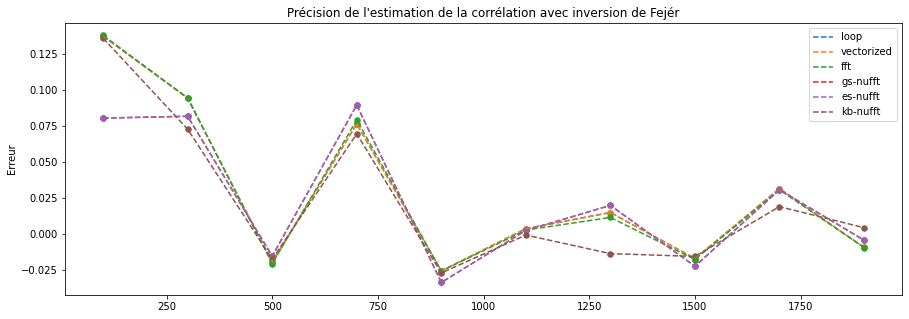

In [61]:
corr_fej["gs-nufft"] = corr_fej["gs-nufft"]
corr_fej["kb-nufft"] = corr_fej["kb-nufft"]
corr_fej["es-nufft"] = corr_fej["es-nufft"]
plt.figure(figsize=(15,5))
for methode in ["loop", "vectorized", "fft", "gs-nufft", "es-nufft", "kb-nufft"] : 
    plt.plot(num_points,np.asarray(corr_fej[methode])-0.35, '--' ,label=methode)
    plt.scatter(num_points, np.asarray(corr_fej[methode])-0.35, s=30)
plt.title("Précision de l'estimation de la corrélation avec inversion de Fejér")
plt.ylabel("Erreur")
plt.legend()
plt.show()

### Dirichlet

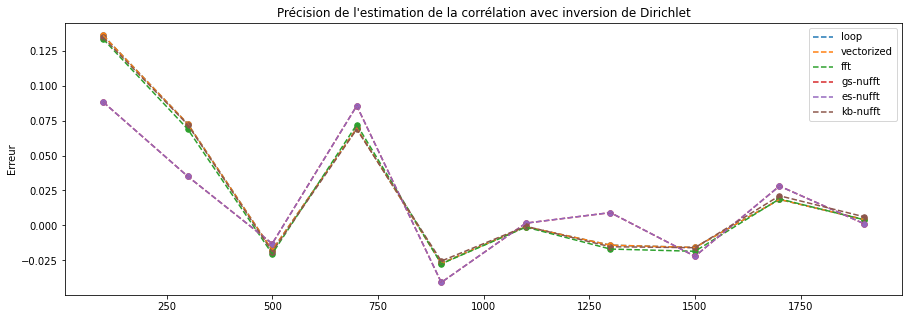

In [62]:
corr_dir["gs-nufft"] = corr_dir["gs-nufft"]
corr_dir["kb-nufft"] = corr_dir["kb-nufft"]
corr_dir["es-nufft"] = corr_dir["es-nufft"]
plt.figure(figsize=(15,5))
for methode in ["loop", "vectorized", "fft", "gs-nufft", "es-nufft", "kb-nufft"] : 
    plt.plot(num_points,np.asarray(corr_dir[methode])-0.35, '--', label=methode)
    plt.scatter(num_points, np.asarray(corr_dir[methode])-0.35, s=30)
plt.title("Précision de l'estimation de la corrélation avec inversion de Dirichlet")
plt.ylabel("Erreur")
plt.legend()
plt.show()

## Etude de la tolérance

In [105]:
def syn_tol_tests(points, nbr) :
    temps = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fej = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dir = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fejco = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dirco = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}

    dt = 1/86400

    mu = [0.01]*nbr
    sigmas = [np.sqrt(0.1)]*nbr
    corrs = 2*np.random.random_sample((nbr,nbr)) - 1
    np.fill_diagonal(corrs, 1)
    Cov = cov_matrix(sigmas, corrs)
    start_price = [100]*nbr
    time_vect = [i*dt for i in range(10000)]
    tmax = time_vect[-1]
    tmin = time_vect[0]

    for tol in points :

        S = GBM(mu, Cov, start_price, time_vect)
        for methode in ["gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == 'kb-nufft' :
                N = Nyquist_freq(time_rescale(time_vect, 1), 1)
            else :
                N = Nyquist_freq(time_rescale(time_vect, 2*np.pi),2*np.pi)
            k, t = fourier_coefficients(S, time_vect, 2*N+1, method=methode, tol=tol)
            temps[methode].append(t)
            est_fej = np.asarray(int_covol_FEJ(k))/(tmax-tmin)
            est_dir = np.asarray(int_covol_DIR(k))/(tmax-tmin)
            erreur_fej[methode].append(Cov[0][0] - est_fej[0][0])
            erreur_dir[methode].append(Cov[0][0] - est_dir[0][0])
            erreur_fejco[methode].append(Cov[1][0] - est_fej[1][0])
            erreur_dirco[methode].append(Cov[1][0] - est_dir[1][0])

    return temps, erreur_fej, erreur_dir, erreur_fejco, erreur_dirco

def asyn_tol_tests(points, nbr, percent) :
    temps = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fej = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dir = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fejco = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dirco = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    
    dt = 1/86400
        
    mu = [0.01]*nbr
    sigmas = [np.sqrt(0.1)]*nbr
    corrs = 2*np.random.random_sample((nbr,nbr)) - 1
    np.fill_diagonal(corrs, 1)
    Cov = cov_matrix(sigmas, corrs)
    start_price = [100]*nbr
    time_vect = [i*dt for i in range(10000)]
    tmax = time_vect[-1]
    tmin = time_vect[0]
    
    for tol in points :
        S = GBM(mu, Cov, start_price, time_vect)
        new_times, new_prices = downsample(time_vect, S, percent)
        for methode in ["gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == 'kb-nufft' :
                N = Nyquist_freq(time_rescale(time_vect, 1), 1)
            else :
                N = Nyquist_freq(time_rescale(time_vect, 2*np.pi),2*np.pi)
            k, t = asyn_fourier_coeffs(new_times, new_prices, 2*N+1, method=methode, tol=tol)
            temps[methode].append(t)
            est_fej = np.asarray(int_covol_FEJ(k))/(tmax-tmin)
            est_dir = np.asarray(int_covol_DIR(k))/(tmax-tmin)
            erreur_fej[methode].append(Cov[0][0] - est_fej[0][0])
            erreur_dir[methode].append(Cov[0][0] - est_dir[0][0])
            erreur_fejco[methode].append(Cov[1][0] - est_fej[1][0])
            erreur_dirco[methode].append(Cov[1][0] - est_dir[1][0])

    return temps, erreur_fej, erreur_dir, erreur_fejco, erreur_dirco

def expo_asyn_tol_tests(points, nbr, lambdas) :
    temps = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fej = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dir = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fejco = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dirco = {'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    
    dt = 1/86400
        
    mu = [0.01]*nbr
    sigmas = [np.sqrt(0.1)]*nbr
    corrs = 2*np.random.random_sample((nbr,nbr)) - 1
    np.fill_diagonal(corrs, 1)
    Cov = cov_matrix(sigmas, corrs)
    start_price = [100]*nbr
    time_vect = [i*dt for i in range(10000)]
    tmax = time_vect[-1]
    tmin = time_vect[0]
    
    for tol in points :
        S = GBM(mu, Cov, start_price, time_vect)
        new_times, new_prices = exponential_arrival(lambdas, time_vect, S)
        for methode in ["gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == 'kb-nufft' :
                N = Nyquist_freq(time_rescale(time_vect, 1), 1)
            else :
                N = Nyquist_freq(time_rescale(time_vect, 2*np.pi),2*np.pi)
            k, t = asyn_fourier_coeffs(new_times, new_prices, 2*N+1, method=methode, tol=tol)
            temps[methode].append(t)
            est_fej = np.asarray(int_covol_FEJ(k))/(tmax-tmin)
            est_dir = np.asarray(int_covol_DIR(k))/(tmax-tmin)
            erreur_fej[methode].append(Cov[0][0] - est_fej[0][0])
            erreur_dir[methode].append(Cov[0][0] - est_dir[0][0])
            erreur_fejco[methode].append(Cov[1][0] - est_fej[1][0])
            erreur_dirco[methode].append(Cov[1][0] - est_dir[1][0])

    return temps, erreur_fej, erreur_dir, erreur_fejco, erreur_dirco

In [ ]:
l = [0]*len(points)
temps = {'gs-nufft' : l, 'kb-nufft': l, 'es-nufft' : l}
erreur_fej = {'gs-nufft' : l, 'kb-nufft': l, 'es-nufft' : l}
erreur_dir = {'gs-nufft' : l, 'kb-nufft': l, 'es-nufft' : l}
erreur_fejco = {'gs-nufft' : l, 'kb-nufft': l, 'es-nufft' : l}
erreur_dirco = {'gs-nufft' : l, 'kb-nufft': l, 'es-nufft' : l}
for _ in range(reps) :
    t, err_fej, err_dir, err_fejco, err_dirco = syn_tol_tests(points, 2)
    for methode in t.keys() :
        temps[methode] = [sum(x) for x in zip(temps[methode], t[methode])]
        erreur_fej[methode] = [sum(x) for x in zip(erreur_fej[methode], err_fej[methode])]
        erreur_dir[methode] = [sum(x) for x in zip(erreur_dir[methode], err_dir[methode])]
        erreur_fejco[methode] = [sum(x) for x in zip(erreur_fejco[methode], err_fejco[methode])]
        erreur_dirco[methode] = [sum(x) for x in zip(erreur_dirco[methode], err_dirco[methode])]
tps = pd.DataFrame.from_dict(temps) 
erf = pd.DataFrame.from_dict(erreur_fej)
erd = pd.DataFrame.from_dict(erreur_dir)
erfco = pd.DataFrame.from_dict(erreur_fejco)
erdco = pd.DataFrame.from_dict(erreur_dirco)
tps = tps.div(reps)
erf = erf.div(reps)
erd = erd.div(reps)
erfco = erf.div(reps)
erdco = erd.div(reps)

# Etude de l'estimateur de Malliavin Mancino

## Distribution des erreurs d'estimation

In [114]:
def syn_time_tests(points, nbr) :
    temps = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fej = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dir = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fejco = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dirco = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}

    for n in points :
        print(n)
        dt = 1/86400
        mu = [0.01]*nbr
        sigmas = [np.sqrt(0.1)]*nbr
        corrs = 2*np.random.random_sample((nbr,nbr)) - 1
        np.fill_diagonal(corrs, 1)
        Cov = cov_matrix(sigmas, corrs)
        start_price = [100]*nbr
        time_vect = [i*dt for i in range(n)]
        tmax = time_vect[-1]
        tmin = time_vect[0]
        S = GBM(mu, Cov, start_price, time_vect)
        for methode in ["loop", "vectorized", "fft", "zfft", "gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == 'kb-nufft' :
                N = Nyquist_freq(time_rescale(time_vect, 1), 1)
            else :
                N = Nyquist_freq(time_rescale(time_vect, 2*np.pi),2*np.pi)
            k, t = fourier_coefficients(S, time_vect, 2*N+1, method=methode)
            temps[methode].append(t)
            est_fej = np.asarray(int_covol_FEJ(k))/(tmax-tmin)
            est_dir = np.asarray(int_covol_DIR(k))/(tmax-tmin)
            erreur_fej[methode].append(Cov[0][0] - est_fej[0][0])
            erreur_dir[methode].append(Cov[0][0] - est_dir[0][0])
            erreur_fejco[methode].append(Cov[1][0] - est_fej[1][0])
            erreur_dirco[methode].append(Cov[1][0] - est_dir[1][0])

    return temps, erreur_fej, erreur_dir, erreur_fejco, erreur_dirco

/Users/lin/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
def asyn_time_tests(points, nbr, percent) :
    temps = {"loop" : [], "vectorized" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fej = {"loop" : [], "vectorized" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dir = {"loop" : [], "vectorized" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fejco = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dirco = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}

    for n in points :
        dt = 1/86400
        mu = [0.01]*nbr
        sigmas = [np.sqrt(0.1)]*nbr
        corrs = 2*np.random.random_sample((nbr,nbr)) - 1
        np.fill_diagonal(corrs, 1)
        Cov = cov_matrix(sigmas, corrs)
        start_price = [100]*nbr
        time_vect = [i*dt for i in range(n)]
        tmax = time_vect[-1]
        tmin = time_vect[0]
        S = GBM(mu, Cov, start_price, time_vect)
        new_times, new_prices = downsample(time_vect, S, percent)
        for methode in ["loop", "vectorized", "zfft", "gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == 'kb-nufft' :
                N = Nyquist_freq(time_rescale(time_vect, 1), 1)
            else :
                N = Nyquist_freq(time_rescale(time_vect, 2*np.pi),2*np.pi)
            k, t = asyn_fourier_coeffs(new_times, new_prices, 2*N+1, method=methode, tol=1e-6)
            temps[methode].append(t)
            est_fej = np.asarray(int_covol_FEJ(k))/(tmax-tmin)
            est_dir = np.asarray(int_covol_DIR(k))/(tmax-tmin)
            erreur_fej[methode].append(Cov[0][0] - est_fej[0][0])
            erreur_dir[methode].append(Cov[0][0] - est_dir[0][0])
            erreur_fejco[methode].append(Cov[1][0] - est_fej[1][0])
            erreur_dirco[methode].append(Cov[1][0] - est_dir[1][0])

    return temps, erreur_fej, erreur_dir, erreur_fejco, erreur_dirco

def exp_asyn_time_tests(points, nbr, lambdas) :
    temps = {"loop" : [], "vectorized" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fej = {"loop" : [], "vectorized" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dir = {"loop" : [], "vectorized" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_fejco = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}
    erreur_dirco = {"loop" : [], "vectorized" : [], "fft" : [], "zfft" : [], 'gs-nufft' : [], 'kb-nufft': [], 'es-nufft' : []}

    for n in points :
        dt = 1/86400
        mu = [0.01]*nbr
        sigmas = [np.sqrt(0.1)]*nbr
        corrs = 2*np.random.random_sample((nbr,nbr)) - 1
        np.fill_diagonal(corrs, 1)
        Cov = cov_matrix(sigmas, corrs)
        start_price = [100]*nbr
        time_vect = [i*dt for i in range(n)]
        tmax = time_vect[-1]
        tmin = time_vect[0]
        S = GBM(mu, Cov, start_price, time_vect)
        new_times, new_prices = exponential_arrival(lambdas, time_vect, S)
        for methode in ["loop", "vectorized", "zfft", "gs-nufft", "kb-nufft", "es-nufft"] :
            if methode == 'kb-nufft' :
                N = Nyquist_freq(time_rescale(time_vect, 1), 1)
            else :
                N = Nyquist_freq(time_rescale(time_vect, 2*np.pi),2*np.pi)
            k, t = asyn_fourier_coeffs(new_times, new_prices, 2*N+1, method=methode, tol=1e-6)
            temps[methode].append(t)
            est_fej = np.asarray(int_covol_FEJ(k))/(tmax-tmin)
            est_dir = np.asarray(int_covol_DIR(k))/(tmax-tmin)
            erreur_fej[methode].append(Cov[0][0] - est_fej[0][0])
            erreur_dir[methode].append(Cov[0][0] - est_dir[0][0])
            erreur_fejco[methode].append(Cov[1][0] - est_fej[1][0])
            erreur_dirco[methode].append(Cov[1][0] - est_dir[1][0])

    return temps, erreur_fej, erreur_dir, erreur_fejco, erreur_dirco

## Simulations Monte-Carlo pour la précision

In [72]:
def mc(reps, n, rho, method, params) :
    """
    Computes the correlation for 2 assets with MM estimator for different N for a given number of experiments
    reps : number of experiments
    n : number of GBM simulated points
    rho : correlation between the simulated assets
    method : downsample method; "exp" for exponential, "unif" for uniform
    params : for exponential downsample the 2 exponential parameters; for uniform, the percentage of downsample (same for both)
    """

    Ns = []
    n1s = []
    n2s = []
    err_fej = []
    err_dir = []

    mu = [0.01, 0.01]
    sigmas = [np.sqrt(0.1), np.sqrt(.2)]
    corrs = [[1, rho], [rho, 1]]
    Cov = cov_matrix(sigmas, corrs)
    start_price = [100, 100]
    dt = 1/86400

    time_vect = [i*dt for i in range(n)]

    pbar = ProgressBar(maxval=reps).start()
    for _ in range(reps) :
        pbar.update(_)
        S = GBM(mu, Cov, start_price, time_vect)

        if method == "exp" :
            new_times, new_prices = exponential_arrival(params, time_vect, S)
        if method == "unif" :
            new_times, new_prices = downsample(time_vect, S, params)

        new_times_res = [time_rescale(t, 2*np.pi) for t in new_times]
        Nmax = min([Nyquist_freq(t, 2*np.pi) for t in new_times_res])

        # Nsp : ensemble des N considérés
        Nsp = list(range(1,100))+list(range(100, 200, 2)) + list(range(200, 1000, 100)) + list(range(1000, min(Nmax,5000), 500)) 
        for N in Nsp :
            d,p = asyn_fourier_coeffs(new_times, new_prices, method='vectorized', tol=1e-6, N=N)
            est_dir = int_covol_DIR(d)
            est_fej = int_covol_FEJ(d)
            err_fej.append(np.abs(est_fej[0][1]/(np.sqrt(est_fej[0][0])*np.sqrt(est_fej[1][1]))-Cov[0][1]/(np.sqrt(Cov[0][0])*np.sqrt(Cov[1][1]))))
            err_dir.append(np.abs(est_dir[0][1]/(np.sqrt(est_dir[0][0])*np.sqrt(est_dir[1][1])) - Cov[0][1]/(np.sqrt(Cov[0][0])*np.sqrt(Cov[1][1]))))
            Ns.append(N)
            n1s.append(len(new_times[0]))
            n2s.append(len(new_times[1]))

    pbar.finish()

    return pd.DataFrame({"N":Ns, "n1":n1s, "n2":n2s, "Erreur Fej" : err_fej, "Erreur Dir" : err_dir})

# Tracé des résultats
def group(df, exposant = 1, step = .1):
    #df["calc"] =  df.N ** (2 * exposant) / (df.n * df.n2)
    df["calc"] =  df.N ** exposant / df[["n1", "n2"]].min(axis=1)
    df.calc = np.log(df.calc)
    df["gr"] = ((df.calc - min(df.calc))/step).astype(int)
    return df.groupby("gr").mean(), df

In [81]:
res = mc(20,500,.3,"unif", .4)

100% (20 of 20) |########################| Elapsed Time: 0:00:35 Time:  0:00:35


dfg,df = group(res)
plt.plot(dfg.calc, dfg["Erreur Fej"], ".", linewidth=.9, markersize=2)

## Comparaison avec l'estimateur de Hayashi Yoshida

In [113]:
def comp(reps, n, steps, method, params) :

    corr_hy, corr_dir, corr_fej, Ns, corr_fej_c, corr_dir_c, Nc = [], [], [], [], [], [], []

    mu = [0.01, 0.01]
    sigmas = [np.sqrt(0.1), np.sqrt(0.2)]
    start_price = [100, 100]
    dt = 1/86400
    time_vect = [i*dt for i in range(n)]

    corr = list(np.linspace(-1, 1, steps))

    for _ in range(reps) :
        for k in corr :
            corrs = [[1, k], [k, 1]]
            Cov = cov_matrix(sigmas, corrs)
            S = GBM(mu, Cov, start_price, time_vect)

            if method == "unif" :
                new_times, new_prices = downsample(time_vect, S, params)
            if method == "exp" :
                new_times, new_prices = exponential_arrival(params, time_vect, S)
            
            # Estimation par HY
            est_hy = hayashi_yoshida(new_prices, new_times)
            corr_hy.append(est_hy[1][0][1])

            # Estimation par MM
            new_times_res = [time_rescale(t, 2*np.pi) for t in new_times]
            N = min([Nyquist_freq(t, 2*np.pi) for t in new_times_res])
            Ns.append(N)
            
            d = asyn_fourier_coeffs(new_times, new_prices, 2*N+1, method='vectorized', tol=1e-6)[0]
            est_dir = int_covol_DIR(d)
            est_fej = int_covol_FEJ(d)

            corr_dir.append(est_dir[0][1]/(np.sqrt(est_dir[0][0])*np.sqrt(est_dir[1][1])))
            corr_fej.append(est_fej[0][1]/(np.sqrt(est_fej[0][0])*np.sqrt(est_fej[1][1])))

            # Correction de N
            nn = min(len(new_times_res[0]), len(new_times_res[1]))
            #Nn = 0.85 * (nn ** (3/4)) # Proposé par MM
            Nn = 0.075 * (nn ** 0.7) # Par régression linéaire
            Nc.append(Nn)

            d = asyn_fourier_coeffs(new_times, new_prices, 2*min(Nn, N)+1, method='vectorized', tol=1e-6)[0]
            est_dir = int_covol_DIR(d)
            est_fej = int_covol_FEJ(d)

            corr_dir_c = est_dir[0][1]/(np.sqrt(est_dir[0][0])*np.sqrt(est_dir[1][1]))
            corr_fej_c = est_fej[0][1]/(np.sqrt(est_fej[0][0])*np.sqrt(est_fej[1][1]))

            return pd.DataFrame({"correlation":corr, "HY":corr_hy, "Fej":corr_fej, "Dir":corr_dir, "N":Ns, "Fej_c":corr_fej_c, "Dir_c":corr_dir_c, "Nc":Nc})